Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Start of file: 'Gammaproteobacteria,0.04415611593596317,0.09294976'
End of file: '\nGadus,0.0,0.0,0.0,0.0,0.00027104678267468965,0.0\n'
['Nitrosopumilus', '0.0035314429214188554', '0.01885147651738041', '0.01264459326558329', '0.009984059065357832', '0.05420935653493793', '0.010675146215433536']
['Nitrosococcus', '0.007638380244846709', '0.011005775307834805', '0.010115674612466633', '0.00948066112928937', '0.007264053775681682', '0.009198796206916132']
['Nitrosomonas', '0.002485089463220676', '0.005611855726272202', '0.004027537114222826', '0.003020387616410773', '0.004770423375074538', '0.0034637442507523706']
['Nitrococcus', '0.0022496599351260857', '0.0033780102429988015', '0.0032313960567601743', '0.0029364879603993622', '0.0027104678267468965', '0.003179830787575947']
['Nitrospira', '0.001961912734121586', '0.0029966219897570013', '0.00257575048002622

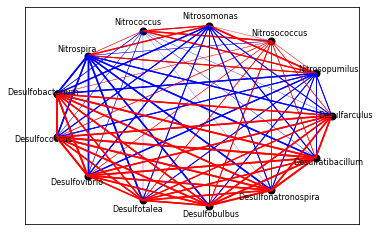

['Nitrosopumilus', 'Nitrosococcus', 'Nitrosomonas', 'Nitrococcus', 'Nitrospira', 'Desulfobacterium', 'Desulfococcus', 'Desulfovibrio', 'Desulfotalea', 'Desulfobulbus', 'Desulfonatronospira', 'Desulfatibacillum', 'Desulfarculus']


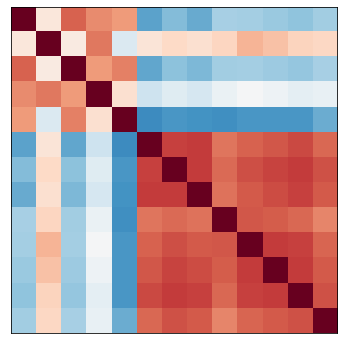

In [20]:
# Search for keywords for covariance circle plots
import numpy as np
import math
from scipy import linalg
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf, empirical_covariance
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from google.colab import drive
drive.mount('/content/gdrive')
# #############################################################################
infile = "/content/gdrive/Shared drives/4.Venetian Canals/Joined MG Files/Genus.Frqs.All.MGs.Joined.csv"
with open(infile, 'r') as f:
  data = f.read() 
  print('Start of file:',repr(data[:50]))
  print('End of file:', repr(data[-50:]))
f.close()
lines = data.split('\n')
lines.pop()

# specify keywords in the order you them to be plotted
Keywords = [ 'nitro', 'sulfo', 'sulfa' ]
         
n_samples = 80

table, genera = [], []
for x in range(len(Keywords)):
  for y in range(100):
    row = lines[y].split(',')
    if Keywords[x].lower() in row[0].lower():
      print(row)
      genera.append(row[0])
      for y in range(1, len(row)):
        if float(row[y]) > 0.0: row[y] = 1/float(row[y])
        else: row[y] = 10000
      table.append(row[1:])
print()

frame ={}
for x in range(len(table)):
  frame[ genera[x] ] = table[x]  
print(frame)

df = pd.DataFrame(frame)
print()
#print('df', df)
covMatrix = pd.DataFrame.cov(df)
print ('covMatrix:\n', covMatrix)

#plt.matshow(covMatrix, cmap='Reds')  #RdBu_r, spring, autumn, Reds, plasma, RdPu, Purples, jet
#plt.show()

cov = linalg.inv(covMatrix)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
covMatrix *= d
covMatrix *= d[:, np.newaxis]
X = df  
X -= X.mean(axis=0)
X /= X.std(axis=0)

# #############################################################################
# Estimate the covariance
emp_cov = np.dot(X.T, X) / n_samples
model =  GraphicalLassoCV()   
model.fit(X)
covGL = model.covariance_
lw_prec_ = linalg.inv(covGL)

# #############################################################################
# define the plot parameters
 
def circular_plot1(x,y,z):
  plt.plot(m,n,'kx', marker ='o', markersize= '7')#,fillstyle='none')
  labels = [coords[i-1][0][:] for i in range(1,len(genera)+1)]  #'{0}'.format(i) +' '+  FOR PUTTING  NUMBERS IN FRONT OF TAXON NAMES
  for label in range(len(genera)):
    plt.annotate(labels[label], xy = (p[label], q[label]), xytext = (0, 0), textcoords = 'offset points', va='center', ha='center', fontsize=8)   
  plt.xlim(-1.2,1.2)
  plt.ylim(-1.2,1.2)

# Plot the results
m, n, p, q, r, s, kx, ky =[], [], [], [], [], [], [], []
coords =[]
for w in range(0, len(genera)):
   x = (math.cos(2 * math.pi * (w +1) / (len(genera))))
   y = (math.sin(2 * math.pi * (w +1) / (len(genera))))
   e = x * 1.5
   f = y * 1.5
   m.append(x)
   n.append(y)
   p.append(x * 1.1)
   q.append(y * 1.1)
   coords.append([genera[w][:], [m[w], n[w]]])
circular_plot1(m,n,'k+')
plt.xticks(())
plt.yticks(())

lw =3
for a1 in range(len(genera)):
  for b1 in range(len(genera)):
    if covGL[a1][b1] >0:
      plt.plot([coords[a1][1][0], coords[b1][1][0]] , [coords[a1][1][1], coords[b1][1][1]], color = 'r', linewidth= covGL[a1][b1] * lw)
    else: 
      plt.plot([coords[a1][1][0], coords[b1][1][0]] , [coords[a1][1][1], coords[b1][1][1]], color = 'b', linewidth= covGL[a1][b1] * lw)
plt.show()

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
#print('Graphical Lasso Covariance:\n', covGL)
print(genera)       
vmax = covGL.max()
plt.imshow(covGL, interpolation='nearest', vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r)
plt.xticks(())
plt.yticks(())
#plt.title('Graphical Lasso CV')
plt.show()
